In [7]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

# Reading Data from Files

In [8]:
fileprefix = "pilot_2" # pilot_[1,2]
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [9]:
# Testing getting expected score of one trial

with open(all_part_paths[1], 'r') as f:
    participant = json.load(f)

for idx, trial in enumerate(participant['data']):
    trial_type = trial['trialdata']['trial_type']
    try:
        trial_id = str(trial['trialdata']['trial_id'])
    except KeyError:
        trial_id = ""
        
    if trial_type == "mouselab-mdp" and not trial_id.startswith("practice"):
        selected_trial = trial
        break

g_truth = [0.0] + selected_trial['trialdata']['stateRewards'][1:]
mEnv = MouselabEnv.new_symmetric_registered('high_increasing', ground_truth=g_truth)
clicks = selected_trial['trialdata']['queries']['click']['state']['target']
clicks = [int(click) for click in clicks]
for click in clicks:
    mEnv.step(clicks[0])
mEnv._state
# mEnv._term_reward()

(0, -2.0, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat, Cat)

# Analyzing Trial Data

In [10]:
part_stats_dicts = []
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    rewardsWithheld = []
    effort = "-1"
    
    firstTrialStamp = participant['data'][0]['dateTime']
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    stroop_timestamps = {
        "1" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        },
        "2" : {
            "start" : 0,
            "end" : 0,
            "done" : False
        }
    }
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    stroop1Completed = 0
    stroop1Correct = 0
    stroop2Completed = 0
    stroop2Correct = 0
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
#         if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
#             print("{}\t{}\t{}".format(trial_type, trial_id, idx))
        if trial_id == "stroop_1_ready_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["start"] = trial['dateTime']
            
        if trial_id == "stroop_2_ready_1" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["start"] = trial['dateTime']
            
        if trial_id == "finish_distractor_1" and not stroop_timestamps["1"]["done"]:
            stroop_timestamps["1"]["end"] = trial['dateTime']
            stroop_timestamps["1"]["done"] = True
            
        if trial_id == "finish_distractor_2" and not stroop_timestamps["2"]["done"]:
            stroop_timestamps["2"]["end"] = trial['dateTime']
            stroop_timestamps["2"]["done"] = True
            
        if trial_id == "mouselab_instructions_1" and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        if "congruent" in trial_id or "incongruent" in trial_id or "unrelated" in trial_id:
            if not stroop_timestamps["1"]["done"]:
                stroop1Completed += 1
                
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop1Correct += 1
                
            else:
                stroop2Completed += 1
                if trial['trialdata']["response"].lower() == trial['trialdata']["correct_response"].lower():
                    stroop2Correct += 1
                    
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                
                # Getting expected scores
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('high_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                for click in clicks:
                    mEnv.step(int(click))
                
                expectedScores.append(mEnv._term_reward() + trial['trialdata']['costs'])
                
        if trial_type == 'survey-html-form':
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
        if trial_type == 'survey-text':
            feedback = trial['trialdata']['response']['Q0']
            comments = trial['trialdata']['response']['Q2']
        last_trial = trial

    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps, stroop_timestamps["1"], stroop_timestamps["2"]], ["mdp", "s1", "s2"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
            
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "condition": participant['condition'],
        "stroop1Length" : (stroop_timestamps["1"]["end"] - stroop_timestamps["1"]["start"]) / 1000,
        "stroop2Length" : (stroop_timestamps["2"]["end"] - stroop_timestamps["2"]["start"]) / 1000,
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "stroop1Completed" : stroop1Completed,
        "stroop2Completed" : stroop2Completed,
        "stroop1Correct" : stroop1Correct,
        "stroop2Correct" : stroop2Correct,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["stroop1Length"] + part_stats_dict["mouselabLength"] + part_stats_dict["stroop2Length"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

In [11]:
# Compiling all data into trial data

all_trial_data = {
    "trialScores": [],
    "expectedScores": [],
    "trialNumbers": [],
    "scarce": [],
    "numRewardedTrials": [],
    "numUnrewardedTrials": [],
    "workerId": []
}

for part in part_stats_dicts:
    if len(part['trialScores']) not in [30, 120]:
        continue
    all_trial_data['trialScores'] += part['trialScores']
    all_trial_data['workerId'] += [part['workerId']] * len(part['trialScores'])
    all_trial_data['expectedScores'] += part['expectedScores']
    all_trial_data['trialNumbers'] += list(range(1,len(part['trialScores'])+1))
    all_trial_data['scarce'] += [int(len(part['trialScores']) == 120)] * len(part['trialScores'])
    all_trial_data['numRewardedTrials'] += [i - sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]
    all_trial_data['numUnrewardedTrials'] += [sum(part['rewardsWithheld'][0:i]) for i in range(len(part['trialScores']))]

all_trials_df = pd.DataFrame(all_trial_data)


In [12]:
all_trials_df

,trialScores,expectedScores,trialNumbers,scarce,numRewardedTrials,numUnrewardedTrials,workerId
0,38.0,9.0,1,0,0,0,6140be2fdc5e6f433f412f7a
1,30.0,1.0,2,0,1,0,6140be2fdc5e6f433f412f7a
2,30.0,25.0,3,0,2,0,6140be2fdc5e6f433f412f7a
3,25.0,20.0,4,0,3,0,6140be2fdc5e6f433f412f7a
4,52.0,-1.0,5,0,4,0,6140be2fdc5e6f433f412f7a
...,...,...,...,...,...,...,...
2935,40.0,35.0,26,0,25,0,6130ceb2390f7cb3284f33a9
2936,31.0,26.0,27,0,26,0,6130ceb2390f7cb3284f33a9
2937,26.0,21.0,28,0,27,0,6130ceb2390f7cb3284f33a9
2938,58.0,53.0,29,0,28,0,6130ceb2390f7cb3284f33a9


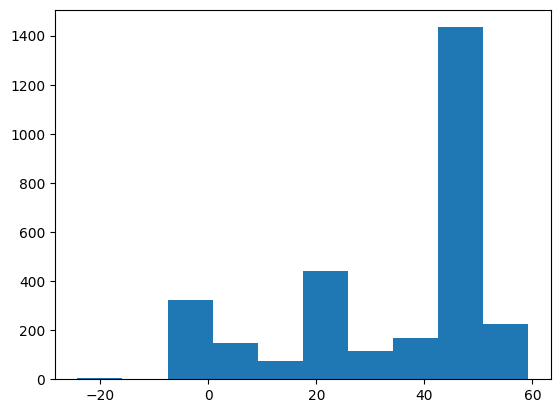

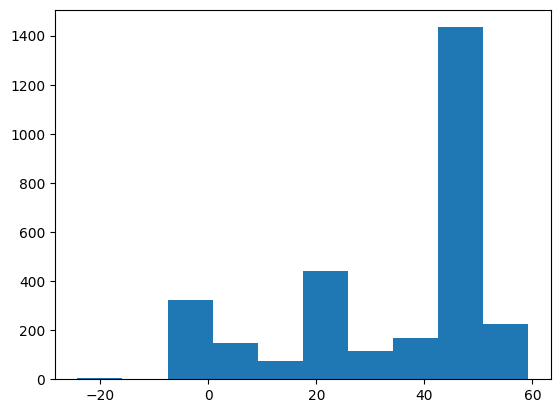

In [31]:
# Transforming the data

transformed_trials_df = all_trials_df.copy()
log_transformed_trials_df = all_trials_df.copy()
sq_transformed_trials_df = all_trials_df.copy()
cb_transformed_trials_df = all_trials_df.copy()

plt.figure()
plt.hist(transformed_trials_df['expectedScores'])
log_transformed_trials_df['expectedScores'] = np.log(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
sq_transformed_trials_df['expectedScores'] = np.sqrt(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])
cb_transformed_trials_df['expectedScores'] = np.cbrt(transformed_trials_df['expectedScores'].max() + 1 - transformed_trials_df['expectedScores'])

plt.figure()
plt.hist(transformed_trials_df['expectedScores'])
plt.show()

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expectedScores
No. Observations:     2940       Method:                REML          
No. Groups:           41         Scale:                 0.3667        
Min. group size:      30         Log-Likelihood:        -2774.3372    
Max. group size:      120        Converged:             Yes           
Mean group size:      71.7                                            
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    3.274    0.093 35.111 0.000  3.092  3.457
C(scarce)[T.1]              -0.059    0.129 -0.453 0.651 -0.312  0.195
trialNumbers                -0.008    0.003 -3.010 0.003 -0.014 -0.003
trialNumbers:C(scarce)[T.1]  0.004    0.003  1.506 0.132 -0.001  0.010
Group Var              

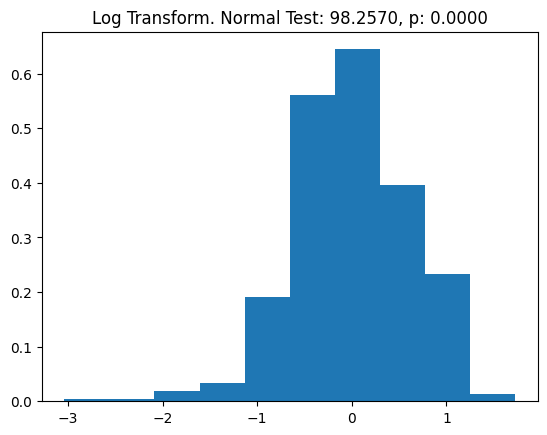

In [27]:
# GLM Model 1 - Expected score vs. Trial number & Condition - log transform

formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=log_transformed_trials_df, groups=log_transformed_trials_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=log_transformed_trials_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Log Transform. Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expectedScores
No. Observations:     2940       Method:                REML          
No. Groups:           41         Scale:                 1.9346        
Min. group size:      30         Log-Likelihood:        -5221.8796    
Max. group size:      120        Converged:             Yes           
Mean group size:      71.7                                            
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    5.470    0.243 22.529 0.000  4.994  5.946
C(scarce)[T.1]              -0.085    0.341 -0.248 0.804 -0.753  0.584
trialNumbers                -0.023    0.006 -3.746 0.000 -0.036 -0.011
trialNumbers:C(scarce)[T.1]  0.012    0.006  1.938 0.053 -0.000  0.025
Group Var              

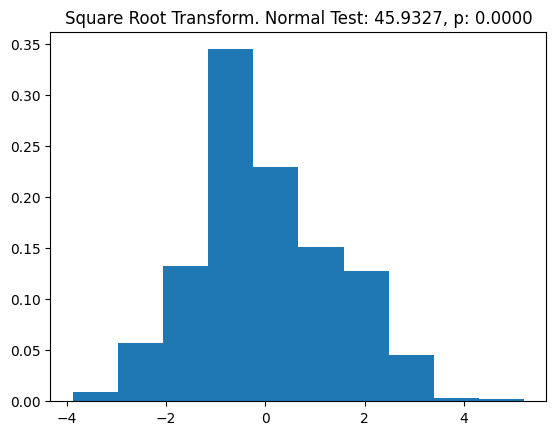

In [28]:
# GLM Model 1 - Expected score vs. Trial number & Condition - square root transform

formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=sq_transformed_trials_df, groups=sq_transformed_trials_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=sq_transformed_trials_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Square Root Transform. Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    expectedScores
No. Observations:     2940       Method:                REML          
No. Groups:           41         Scale:                 0.3016        
Min. group size:      30         Log-Likelihood:        -2491.6996    
Max. group size:      120        Converged:             Yes           
Mean group size:      71.7                                            
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    3.064    0.092 33.167 0.000  2.883  3.245
C(scarce)[T.1]              -0.040    0.129 -0.311 0.756 -0.294  0.213
trialNumbers                -0.009    0.002 -3.538 0.000 -0.014 -0.004
trialNumbers:C(scarce)[T.1]  0.005    0.002  1.817 0.069 -0.000  0.009
Group Var              

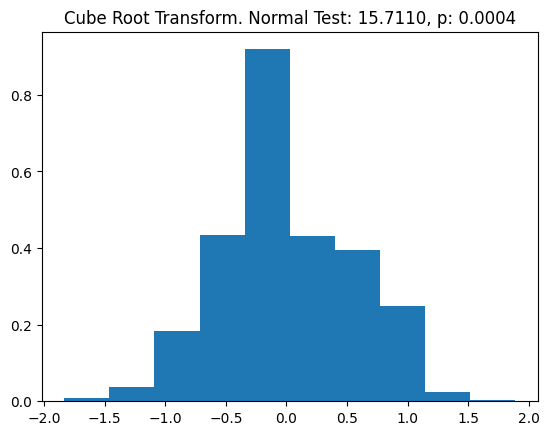

In [32]:
# GLM Model 1 - Expected score vs. Trial number & Condition - cube root transform

formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=cb_transformed_trials_df, groups=cb_transformed_trials_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=cb_transformed_trials_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Cube Root Transform. Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [79]:
data = scipy.stats.norm.rvs(size=3000)
scipy.stats.normaltest(data)

NormaltestResult(statistic=2.7820082289265864, pvalue=0.24882533003839363)

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: expectedScores
No. Observations:   2940    Method:             REML          
No. Groups:         41      Scale:              0.3665        
Min. group size:    30      Log-Likelihood:     -2772.1946    
Max. group size:    120     Converged:          Yes           
Mean group size:    71.7                                      
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            3.245    0.063 51.227 0.000  3.121  3.370
numRewardedTrials   -0.009    0.002 -3.659 0.000 -0.014 -0.004
numUnrewardedTrials -0.002    0.001 -2.708 0.007 -0.004 -0.001
Group Var            0.138    0.054                           



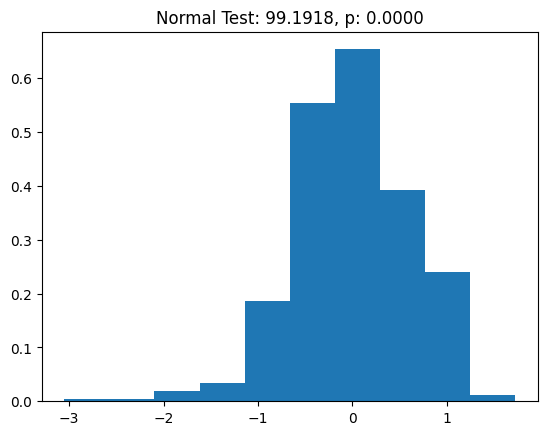

In [80]:
# GLM 2 - Expected score vs num rewarded trials (within group)

scarce_df = transformed_trials_df.loc[transformed_trials_df.scarce == 1]

formula = 'expectedScores ~ numRewardedTrials + numUnrewardedTrials'

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=transformed_trials_df, groups=transformed_trials_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=transformed_trials_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [64]:
# GLM 3 - finding cut off point of learning phase

# For scarce trials
scarce_trials = all_trials_df.loc[all_trials_df.scarce == 1]
for trialNum in range(2,30):
    partition_1_df = scarce_trials.loc[scarce_trials.trialNumbers <= trialNum]
    partition_2_df = scarce_trials.loc[scarce_trials.trialNumbers > trialNum]
    formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"
    glm_1 = smf.glm(formula=formula, data=partition_1_df)
    glm_2 = smf.glm(formula=formula, data=partition_2_df)

    results_1 = glm_1.fit()
    results_2 = glm_2.fit()
    
    z1 = (results_1.params['trialNumbers'] / results_1.bse['trialNumbers'])
    z2 = (results_2.params['trialNumbers'] / results_2.bse['trialNumbers'])
    print(results_1.summary())
    break;
    zscore = np.abs(z1-z2)
    pvalue = 2 * scipy.stats.norm.cdf(-zscore)
    if(pvalue < 0.05): print(trialNum)
    
# For non scarce trials
nonscarce_trials = all_trials_df.loc[all_trials_df.scarce == 0]
for trialNum in range(2,30):
    partition_1_df = nonscarce_trials.loc[nonscarce_trials.trialNumbers <= trialNum]
    partition_2_df = nonscarce_trials.loc[nonscarce_trials.trialNumbers > trialNum]
    formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

    glm_1 = smf.glm(formula=formula, data=partition_1_df)
    glm_2 = smf.glm(formula=formula, data=partition_2_df)

    results_1 = glm_1.fit()
    results_2 = glm_2.fit()
    
    z1 = (results_1.params['trialNumbers'] / results_1.bse['trialNumbers'])
    z2 = (results_2.params['trialNumbers'] / results_2.bse['trialNumbers'])
    zscore = np.abs(z1-z2)
    pvalue = 2 * scipy.stats.norm.cdf(-zscore)
    if(pvalue < 0.05): print(trialNum)
    

                 Generalized Linear Model Regression Results                  
Dep. Variable:         expectedScores   No. Observations:                   38
Model:                            GLM   Df Residuals:                       36
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          399.66
Method:                          IRLS   Log-Likelihood:                -166.71
Date:                Fri, 02 Sep 2022   Deviance:                       14388.
Time:                        16:41:55   Pearson chi2:                 1.44e+04
No. Iterations:                     3   Pseudo R-squ. (CS):           0.001450
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       16.9737     10.255      1.655   